## 1. Import libraries 

In [2]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib notebook

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.cluster import KMeans 
import xgboost

In [4]:
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');

***

## 2. Import data 

In [5]:
folder_path = '../data/'
train_path = os.path.join(folder_path,'train.csv') 
test_path = os.path.join(folder_path, 'test.csv')

In [6]:
df_train = pd.read_csv(train_path)

***

## 3. Data Exploration 

### 3.1 Preliminary Data Scan 

In [7]:
df_train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [9]:
# Get all the non-numeric variables and ascertain unique values
categorical_variables = ['state','area_code','international_plan','voice_mail_plan']
df_train[categorical_variables].nunique()

state                 51
area_code              3
international_plan     2
voice_mail_plan        2
dtype: int64

In [10]:
# Get all numeric variables. number_customer_service_calls is kept aside since it is an integer between 1 and 9
# Can loosely be considered as a categorical variable
numerical_variables = df_train.drop(categorical_variables+['churn','number_customer_service_calls']
                                    ,axis=1).columns.to_list()

**Independent variables** <br>
Thus there are two categorical variables, two binary variables and fourteen continuous numerical variables. 

**Dependent variable** <br>
The target variable 'churn' is also binary i.e. 'Yes' or 'No' 

***

### 3.2 Exploratory Data Analysis (Plots)

In [11]:
# Before we look at possible relationships lets add a new column\
# 'churn_rate' that stores values of 'churn' but converted to integer i.e. "yes" = 1, "no" = 0
df_train['churn_rate'] = df_train['churn'].map({'yes':1, 'no':0})
df_train.drop(columns='churn',axis=1, inplace=True)

##### Categorical variable : international_plan 

In [12]:
df_train.groupby('international_plan')['churn_rate'].mean().reset_index().plot.bar(x='international_plan',y='churn_rate')
plt.ylabel('avg_churn_rate')
plt.title('international_plan influence')
plt.show()

<IPython.core.display.Javascript object>

##### Categorical variable : voice_mail_plan

In [13]:
df_train.groupby('voice_mail_plan')['churn_rate'].mean().reset_index().plot.bar(x='voice_mail_plan',y='churn_rate')
plt.ylabel('avg_churn_rate')
plt.title('voice_mail_plan influence')
plt.show()

<IPython.core.display.Javascript object>

##### Categorical variable : area_code 

In [14]:
df_train.groupby('area_code')['churn_rate'].mean().reset_index().plot.bar(x='area_code',y='churn_rate')
plt.ylabel('avg_churn_rate')
plt.title('area_code influence')
plt.show()

<IPython.core.display.Javascript object>

##### Categorical variable : state 

In [15]:
df_train.groupby('state')['churn_rate'].mean().sort_values()[::5].reset_index().plot.bar(x='state',y='churn_rate')
plt.ylabel('churn_rate')
plt.title('state influence')
plt.show()
# plot every five states to avoid clutter 

<IPython.core.display.Javascript object>

> *Comment*: Thus it appears all categorical variables but area_code are relatively good discriminators of churn

##### Numerical variable : # of Customer Service Calls 

In [16]:
df_train.groupby(['number_customer_service_calls'])['churn_rate'].mean().reset_index().plot(x='number_customer_service_calls',y='churn_rate')
plt.title(' # Customer Service Calls influence')
plt.xlabel('# customer service calls')
plt.ylabel('avg_churn_rate')
plt.show()

<IPython.core.display.Javascript object>

> _Comment_: This makes sense because a high number of customer service calls (complaints) implies either: 
> 1. customer grievances have not been adequately addressed after a few calls (< 3)
> 2. recurring problems necessitating multiple call complaints 

> *Comment*: Before we look at the remaining numerical variables it is prudent to transform them to $charge/calls$ or $charge/min$ since absolute values convey little information

In [17]:
for call_type in ['day','eve','night','intl']:
    df_train[call_type+'_charge_per_min'] = round(df_train['total_'+call_type+'_minutes']/df_train['total_'+call_type+'_charge'],1)
    df_train[call_type+'_charge_per_calls'] = round(df_train['total_'+call_type+'_calls']/df_train['total_'+call_type+'_charge'],1)


In [18]:
df_train[['eve_charge_per_min','day_charge_per_min','night_charge_per_min','intl_charge_per_min']].plot()
plt.ylabel('$charge/min$')
plt.xlabel('#customer')
plt.show()

<IPython.core.display.Javascript object>

> *Comment* : My initial supposition about $charge/min$ being informative was __erroneous__ as observed by the plot above. Moreover this makes sense because the $charge/min$ should be the same for all customers. Also $charge/call$ is meaningless since the extent of any call (how many mins ?) is unknown. <font color=red>Watch this space for improvements (should I have an epiphany)</font>

> Thus all '*charge_per*' columns created above will be removed

In [19]:
df_train.drop([col for col in df_train.columns.to_list() if 'charge_per' in col],axis=1, inplace=True)

***

## 4. Data Preperation  

### 4.1 Encoding categorical columns

In [20]:
oe = OrdinalEncoder()
oe = oe.fit(df_train[categorical_variables]) # Ordinal encoder object 'oe' contains the encoding information \
# which is vital during testing as well as retrieval of original labels, hence saving it
encoder = open('../data/categorical_encoder.pkl','wb')
pickle.dump(oe, encoder)
encoder.close()

categorical_encoded = oe.transform(df_train[categorical_variables])

df_train.loc[:,categorical_variables] = categorical_encoded

### 4.2 Scaling features

In [21]:
scaling = MinMaxScaler()


df_train = pd.DataFrame(columns=df_train.columns.to_list(), data = scaling.fit_transform(df_train))

In [22]:
# keeping the target as type 'int'
df_train['churn_rate'] = df_train['churn_rate'].astype(dtype=int)

***

## 5. Baseline prediction performance

> *Comment* : Lets use the features as is (i.e. minimal transformation) to build a predictor and observe performance. Subsequent improvements will involve transforming a few columns to (hopefully) yield a better performance.

> Lets start by gauging the significance and impact of features 

### 5.1 Initial hint at relevance of features : Logistic Regression

In [23]:
glm_variables = df_train.drop(columns=['churn_rate'],axis=1).columns.to_list()

glm_model = sm.GLM(df_train['churn_rate'],df_train[glm_variables] )
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             churn_rate   No. Observations:                 4250
Model:                            GLM   Df Residuals:                     4231
Model Family:                Gaussian   Df Model:                           18
Link Function:               identity   Scale:                        0.099968
Method:                          IRLS   Log-Likelihood:                -1127.3
Date:                Tue, 06 Jul 2021   Deviance:                       422.96
Time:                        14:53:07   Pearson chi2:                     423.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
state         

> *Comment* : From logitic regression we can see that features like international_plan, voice_mail_plan, number_customer_service_calls etc. are very significant since their p_values ($P>|z|$) are << 0.05 . Also the impact of features can be ascertained by considering observing the magnitude of coefficients , seen below  by taking the exponent of log coefficients

In [24]:
np.exp(res.params).sort_values(ascending=False)

total_day_minutes                3.171323e+89
total_night_minutes              2.967700e+05
total_eve_charge                 1.989276e+05
total_intl_minutes               1.309265e+01
number_customer_service_calls    1.651564e+00
international_plan               1.350409e+00
number_vmail_messages            1.109816e+00
account_length                   9.880218e-01
area_code                        9.877982e-01
state                            9.864778e-01
total_day_calls                  9.145264e-01
total_intl_calls                 8.680787e-01
voice_mail_plan                  8.595471e-01
total_eve_calls                  8.584391e-01
total_night_calls                8.497474e-01
total_intl_charge                8.167508e-02
total_eve_minutes                5.661138e-06
total_night_charge               3.607650e-06
total_day_charge                 4.649644e-90
dtype: float64

> *Comment* : As seen above features like international_plan, total_day_minutes, total_eve_charge affect churn the most. Ultimately the best features are those that are significant and impactful 

### 5.2 Model fitting with XGBoost

> *Comment* : Lets split df_train into train and test. Reason this data frame is called df_train is because after model fitting we will use all the data in df_train to train the model (final step). __There is a yet unseen (test) dataset which we will use for final model evaluation.__


In [25]:
# There is a significant imbalance of churn attributes i.e. No:Yes = 6:1
pd.value_counts(df_train['churn_rate'])

0    3652
1     598
Name: churn_rate, dtype: int64

In [26]:
X = df_train.drop(['churn_rate'], axis = 1)
y = df_train['churn_rate']

# And now splitting into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=30, stratify = y )

In [55]:
# Finding best hyperparameters
xgb_model = xgboost.XGBClassifier(scale_pos_weight = 6, #To balance the churn outcomes
#                               learning_rate = 0.08, 
                              objective = 'binary:logistic', verbosity=0 ,n_jobs=-1).fit(X_train, y_train)
hyper_params = {'max_depth':[3,4,5,6],
        'gamma':[0,0.2,0.4,0.6,0.8],
                'max_delta_step': [0,2,4,6,8,10],
               'learning_rate':[0.08,0.1,0.12,0.18]}
score = 'f1' # Because the classes are imbalanced and weighted avg. of precision & recall is more suitable than ROC
search_results = GridSearchCV(estimator = xgb_model, param_grid = hyper_params, cv = 5, scoring=score ).fit(X_train,y_train)

In [56]:
# Optimal hyperparamters. We will use this in our xgboost model
search_results.best_params_


{'gamma': 0.8, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 6}

In [29]:
xgb_model_optimal = xgboost.XGBClassifier(scale_pos_weight = 6, #To balance the churn outcomes
                              learning_rate = 0.08, 
                              objective = 'binary:logistic',
                                  gamma = search_results.best_params_['gamma'],
                                  max_depth = search_results.best_params_['max_depth'], 
                                  verbosity=0 ,n_jobs=-1).fit(X_train, y_train)

print('Training accuracy: {:.2f}'
       .format(xgb_model_optimal.score(X_train, y_train)))
print('Testing accuracy: {:.2f}'
       .format(xgb_model_optimal.score(X_test[X_train.columns], y_test)))

Training accuracy: 0.99
Testing accuracy: 0.96


In [57]:
xgb_model_optimal = xgboost.XGBClassifier(scale_pos_weight = 6, #To balance the churn outcomes
                              learning_rate = search_results.best_params_['learning_rate'], 
                              max_delta_step = search_results.best_params_['max_delta_step'],
                              objective = 'binary:logistic',
                                  gamma = search_results.best_params_['gamma'],
                                  max_depth = search_results.best_params_['max_depth'], 
                                  verbosity=0 ,n_jobs=-1).fit(X_train, y_train)

print('Training accuracy: {:.2f}'
       .format(xgb_model_optimal.score(X_train, y_train)))
print('Testing accuracy: {:.2f}'
       .format(xgb_model_optimal.score(X_test[X_train.columns], y_test)))

Training accuracy: 0.99
Testing accuracy: 0.96


> *Comment* : Hyper parameter tuning has boosted both training and test score 

In [59]:
y_pred = xgb_model_optimal.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       730
           1       0.87      0.84      0.86       120

    accuracy                           0.96       850
   macro avg       0.92      0.91      0.92       850
weighted avg       0.96      0.96      0.96       850



> *Comment* : Marked improvement in f1 score due to hyper paramter tuning. _See below_ for previous (arbitrary) configuration i.e. max_depth = 4, gamma = 0

#### PR curve

In [53]:
p,r,t = precision_recall_curve(y_test, xgb_model_optimal.predict_proba(X_test)[:,1])

In [60]:
fig = px.line(x=r[:-1], y = p[:-1], hover_name=t)
fig.update_xaxes(title="Recall")
fig.update_yaxes(title="Precision")
fig

*this is a snapshot*
![title](img/past_performance.png)

<IPython.core.display.Javascript object>


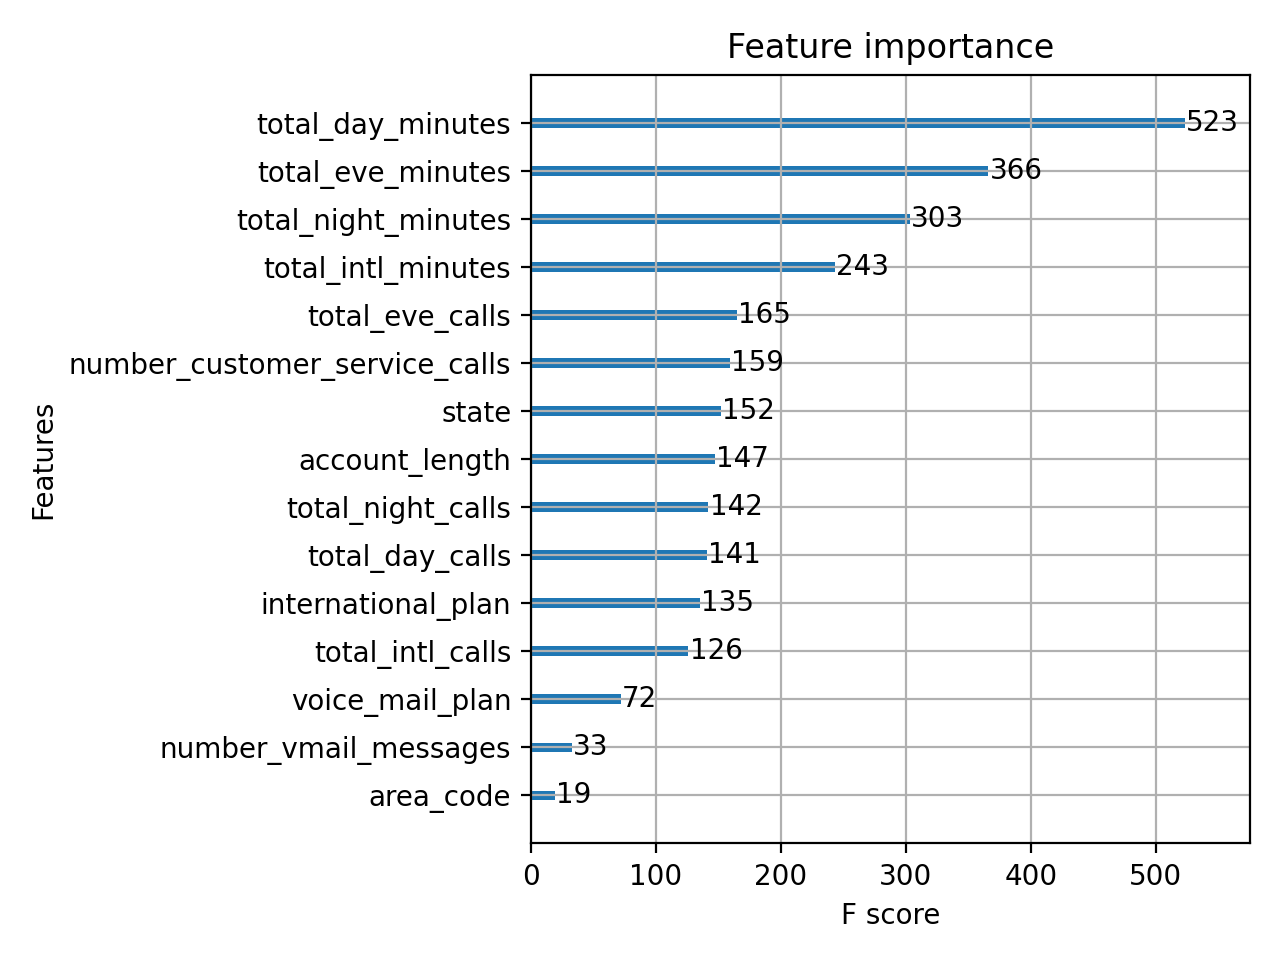

In [105]:
xgboost.plot_importance(xgb_model)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


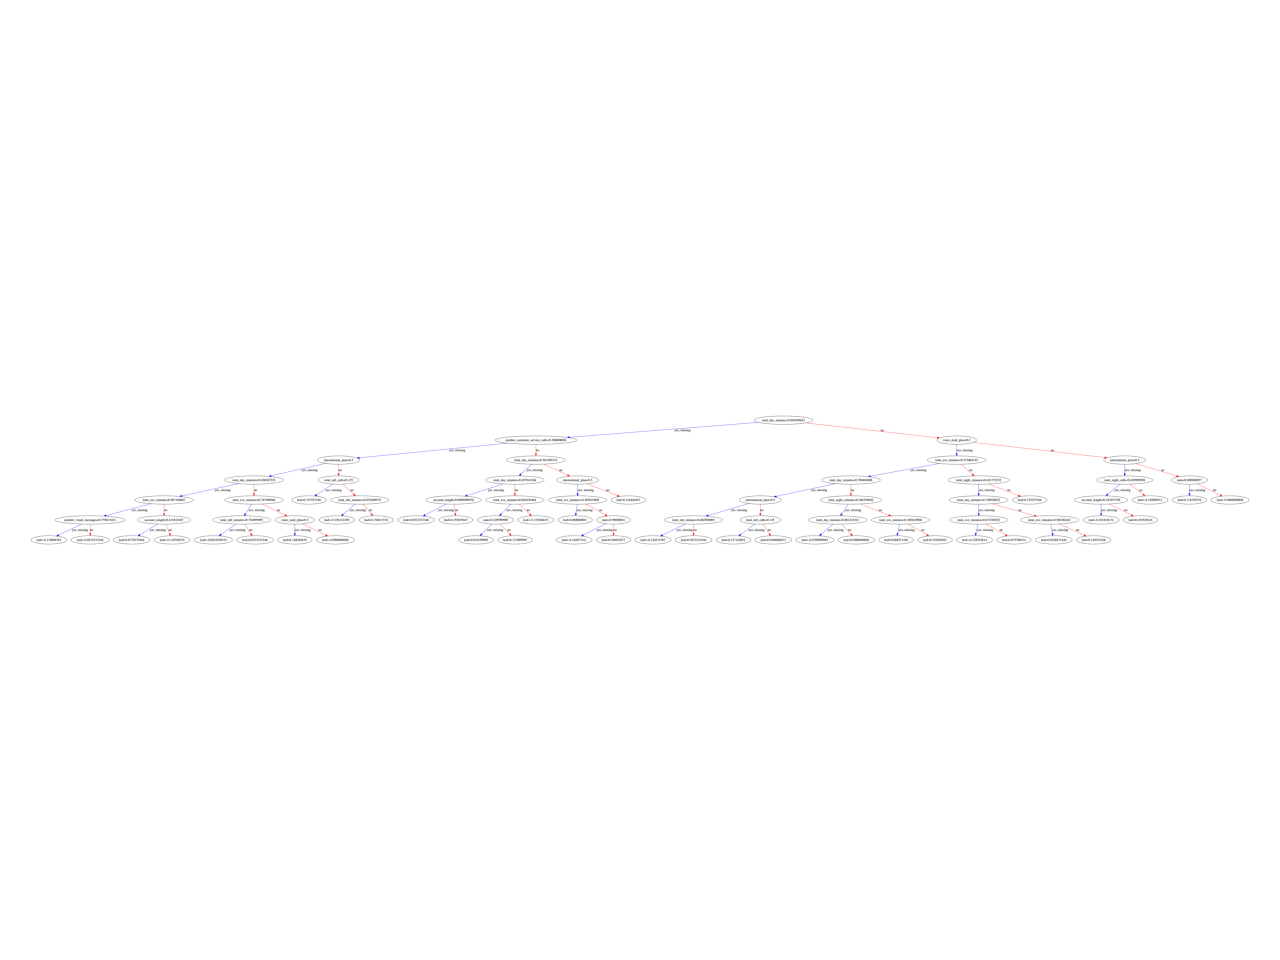

In [106]:
xgboost.plot_tree(xgb_model)
plt.tight_layout()
plt.show()

## 6. Improve prediction performance: clustering  

> *Comment* : 
> 1. We've established a baseline of performance. Lets explore ways to improve the predictive ability specifically the recall rate when a customer churns

> 2. The continuous numeric features perhaps have noise  and a good way to extract more information indeed a clearer way of explanation is to cluster them.


### 6.1 Clustering : Elbow method

> *Comment* : Elbow method is a way to find the optimal number of clusters

In [107]:
df_cluster = pd.DataFrame(index=range(1,11))
for col in numerical_variables:
    df_cluster[col+'_cluster'] = np.NaN
    for k in range(1,11):
        cluster = KMeans(n_clusters=k, max_iter=400).fit(df_train[[col]])
        df_cluster.loc[k,col+'_cluster'] = cluster.inertia_

<IPython.core.display.Javascript object>


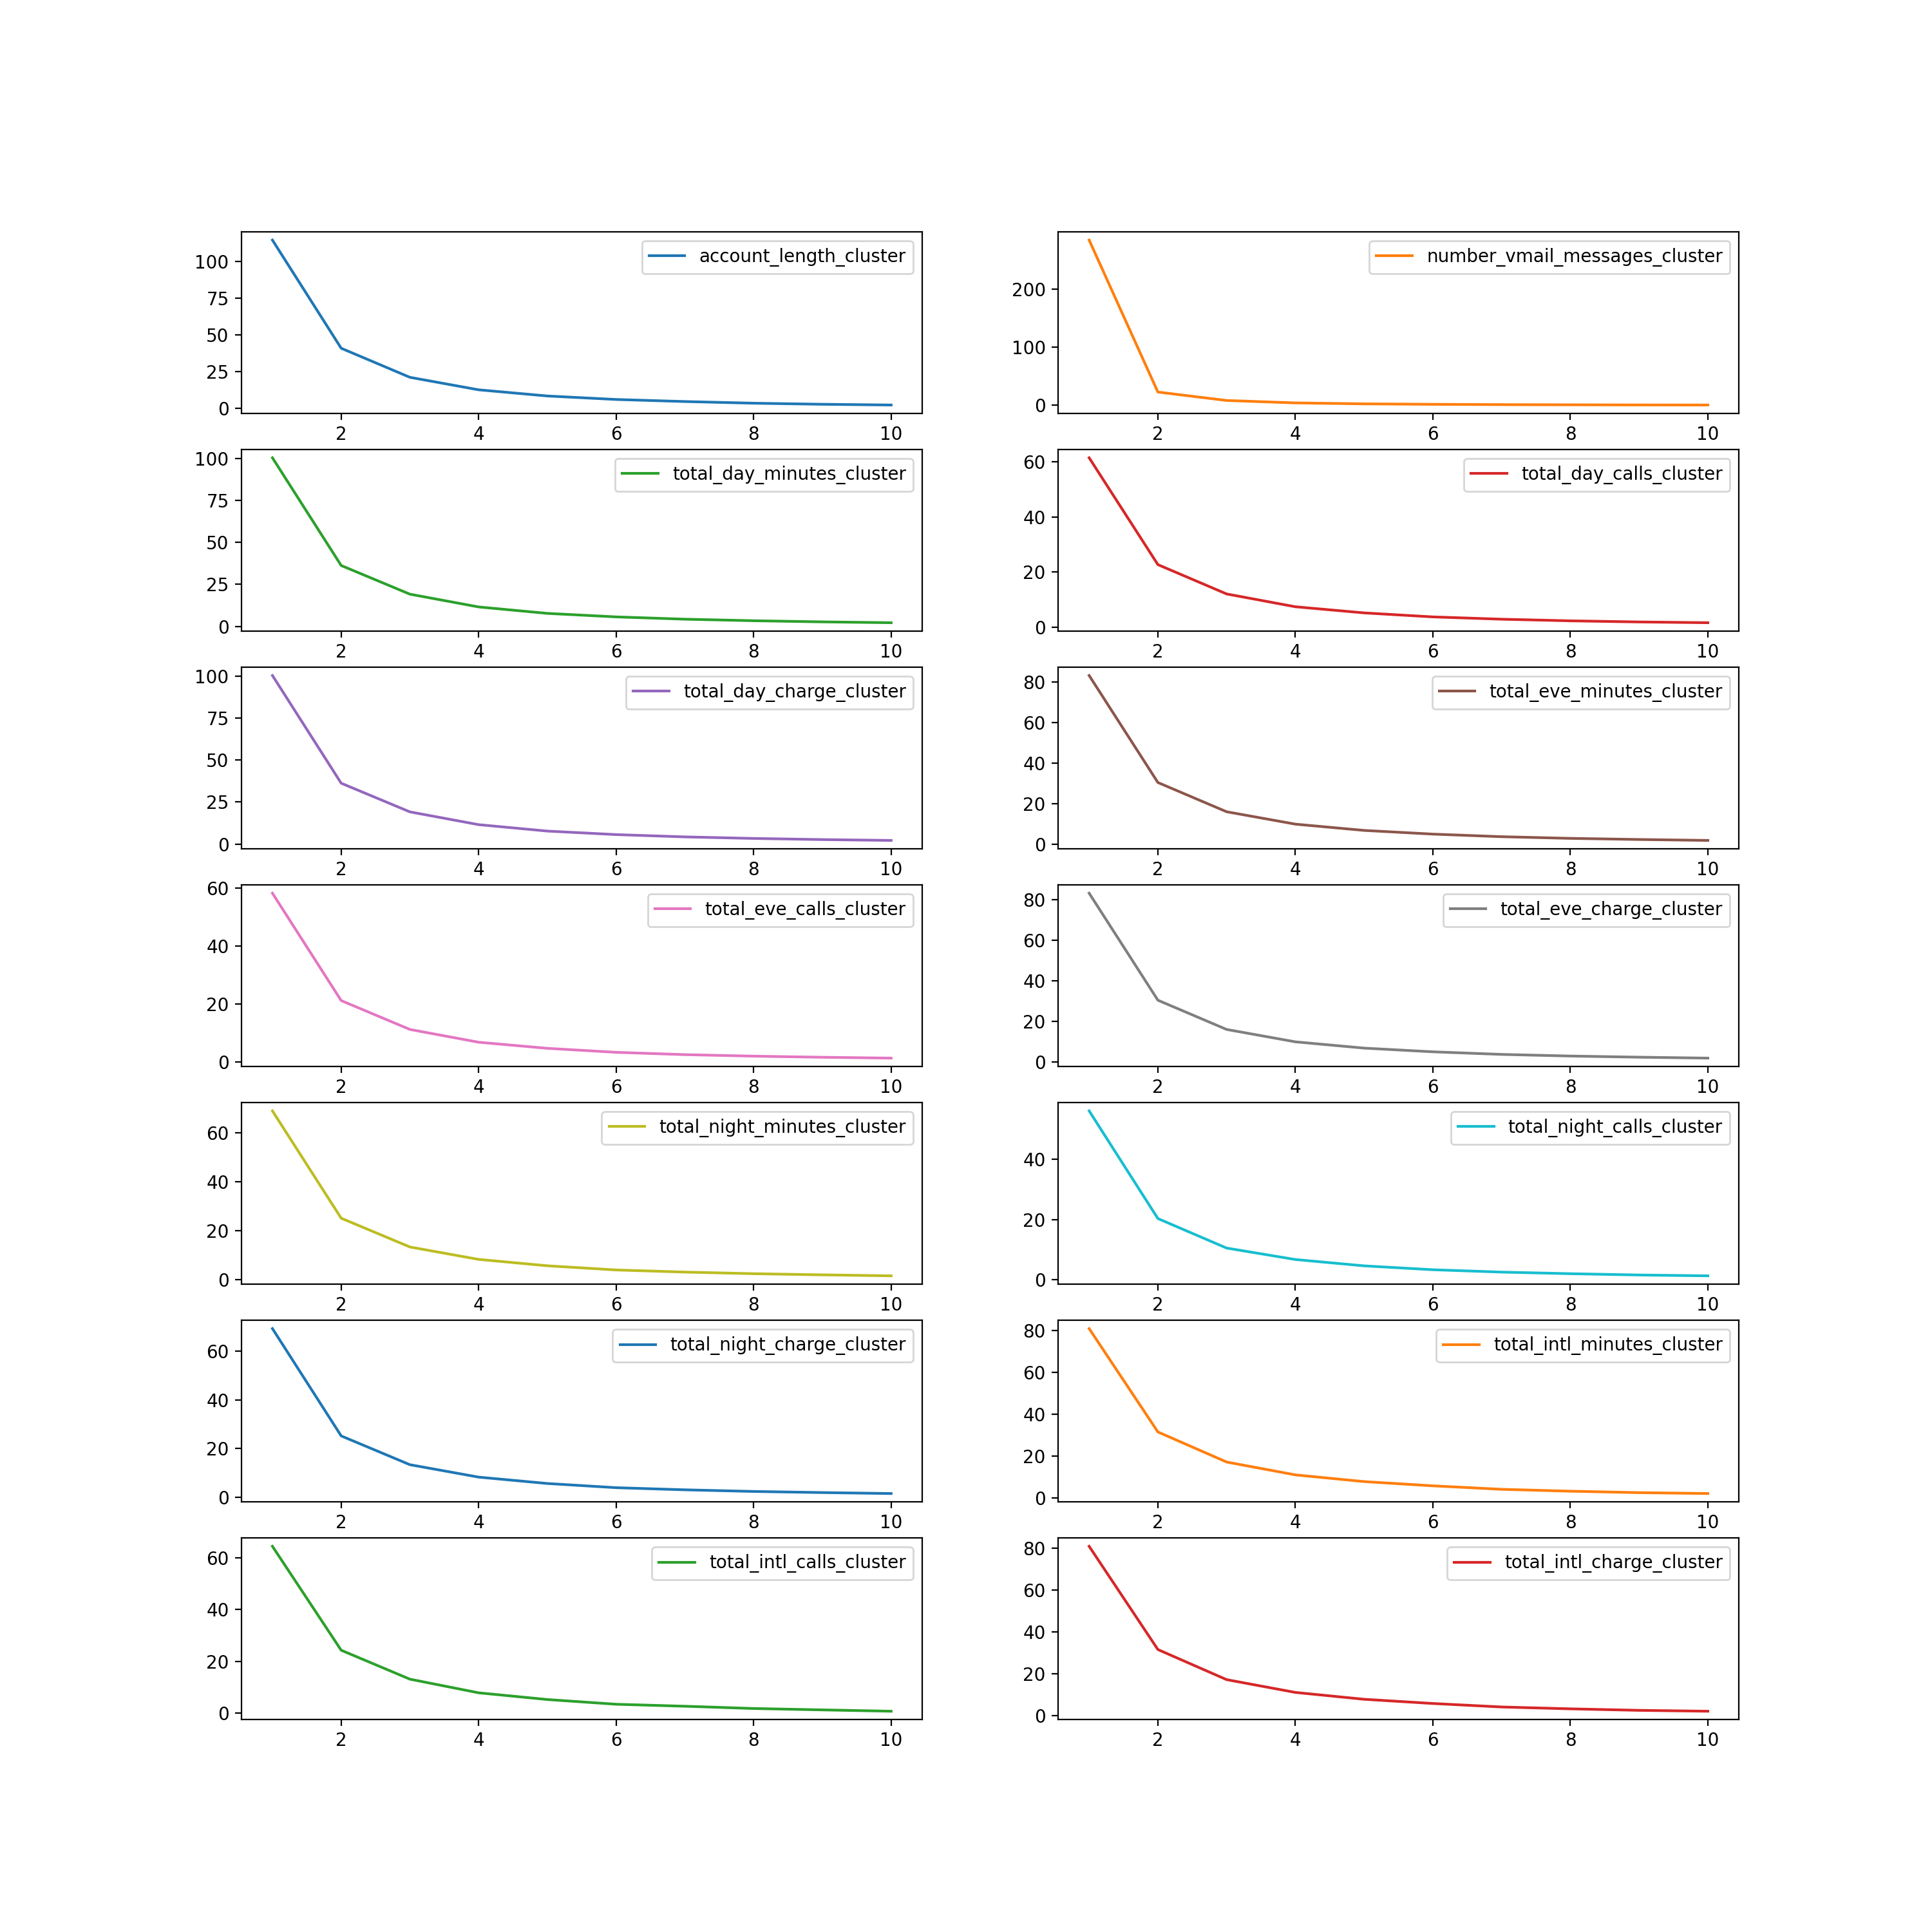

In [43]:
df_cluster.plot(subplots=True, layout=(7,2), figsize=(15,15), sharex=False)
plt.show()

> *Comment* : But for number_vmail_messages all other features are optimally clustered with 4 centroids. number_vmail_messages clusters best with 2 centroids.  

In [108]:
# Doing the needful by creating extra columns s.t. each numerical feature gets a _cluster counterpart
for col in df_train[numerical_variables]:
    if col != 'number_vmail_messages':
        cluster = KMeans(n_clusters = 4, max_iter=400).fit(df_train[[col]])
        df_train[col+'_cluster'] = cluster.predict(df_train[[col]])
        
    else:
        cluster = KMeans(n_clusters = 2, max_iter=400).fit(df_train[[col]])
        df_train[col+'_cluster'] = cluster.predict(df_train[[col]])

In [45]:
df_train.groupby('account_length_cluster')['account_length'].mean()

account_length_cluster
0    0.682025
1    0.350277
2    0.502791
3    0.178021
Name: account_length, dtype: float64

> *Comment* : Notice how the cluster# has no association with centroid magnitudes. This needs to be remedied otherwise information is lost

In [109]:
# Sorting and renaming cluster# according to centroid magnitudes  
for col in numerical_variables:
    idx = df_train.groupby(col+'_cluster')[col].mean().sort_values().index.to_list()
    df_train[col+'_cluster'].replace(idx, list(range(len(idx))), inplace = True)

In [47]:
df_train.groupby('account_length_cluster')['account_length'].mean()

account_length_cluster
0    0.178021
1    0.350277
2    0.502791
3    0.682025
Name: account_length, dtype: float64

> *Comment* : And now the cluster# aligns with the centroid magnitudes

### 6.2 Hint at relevant features: Logistic Regression 

In [48]:
# Removing numerical features and replacing with _cluster counterparts
glm_variables = df_train.drop(numerical_variables+['churn_rate'],axis=1).columns.to_list()

glm_model = sm.GLM(df_train['churn_rate'],df_train[glm_variables], family = sm.families.Binomial())
res = glm_model.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             churn_rate   No. Observations:                 4250
Model:                            GLM   Df Residuals:                     4231
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1538.3
Date:                Mon, 29 Mar 2021   Deviance:                       3076.7
Time:                        15:48:08   Pearson chi2:                 4.51e+03
No. Iterations:                    22                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
state         

In [49]:
np.exp(res.params).sort_values(ascending=False)

number_vmail_messages_cluster    1.256230e+09
total_night_charge_cluster       1.192387e+09
number_customer_service_calls    1.807106e+01
international_plan               6.586058e+00
total_day_minutes_cluster        2.711884e+00
total_intl_charge_cluster        2.656000e+00
total_eve_charge_cluster         1.034579e+00
total_eve_minutes_cluster        9.668899e-01
account_length_cluster           8.220473e-01
total_day_calls_cluster          8.126079e-01
total_intl_calls_cluster         7.641722e-01
total_night_calls_cluster        7.631120e-01
total_eve_calls_cluster          7.283080e-01
area_code                        5.529526e-01
total_day_charge_cluster         4.917179e-01
state                            4.283008e-01
total_intl_minutes_cluster       3.324293e-01
total_night_minutes_cluster      7.854673e-10
voice_mail_plan                  2.398180e-10
dtype: float64

### 6.3 Model fitting with XGBoost 

In [111]:
df_train = pd.DataFrame(columns = df_train.columns.to_list(), data=scaling.fit_transform(df_train))
df_train['churn_rate'] = df_train['churn_rate'].astype(int)

In [112]:
X = df_train.drop(['churn_rate']+numerical_variables, axis=1)
y = df_train['churn_rate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=25, stratify=y )

In [117]:
# Finding best hyperparameters
xgb_model_clustered = xgboost.XGBClassifier(scale_pos_weight = 6, #To balance the churn outcomes
                              learning_rate = 0.08, 
                              objective = 'binary:logistic', verbosity=0 ,n_jobs=-1).fit(X_train, y_train)
hyper_params = {'max_depth':[3,4,5,6],
        'gamma':[0,0.2,0.4,0.6,0.8]}
score = 'f1' # Because the classes are imbalanced and weighted avg. of precision & recall is more suitable than ROC
search_results_clustered = GridSearchCV(estimator = xgb_model_clustered, param_grid = hyper_params, cv = 5, scoring=score ).fit(X_train,y_train)

/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [118]:
search_results_clustered.best_params_

{'gamma': 0.4, 'max_depth': 4}

In [120]:
xgb_model_clustered = xgboost.XGBClassifier(objective='binary:logistic',
                                 max_depth = search_results_clustered.best_params_['max_depth'],
                                            gamma = search_results_clustered.best_params_['gamma'],
                                 scale_pos_weight = 6, learning_rate=0.08, n_jobs=-1).fit(X_train, y_train)

print("Training accuracy : {:.2f}".format(xgb_model_clustered.score(X_train, y_train)))
print("Testing accuracy : {:.2f}".format(xgb_model_clustered.score(X_test[X_train.columns], y_test)))

/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training accuracy : 0.92
Testing accuracy : 0.90


In [121]:
# Lets take a closer look at performance
y_pred = xgb_model_clustered.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       730
           1       0.62      0.80      0.70       120

    accuracy                           0.90       850
   macro avg       0.79      0.86      0.82       850
weighted avg       0.92      0.90      0.91       850



> *Comment* : Modest improvement due to tuning (_see below_) yet __clustering hasn't helped__ 

![title](img/past_performance_clustered.png)

<IPython.core.display.Javascript object>


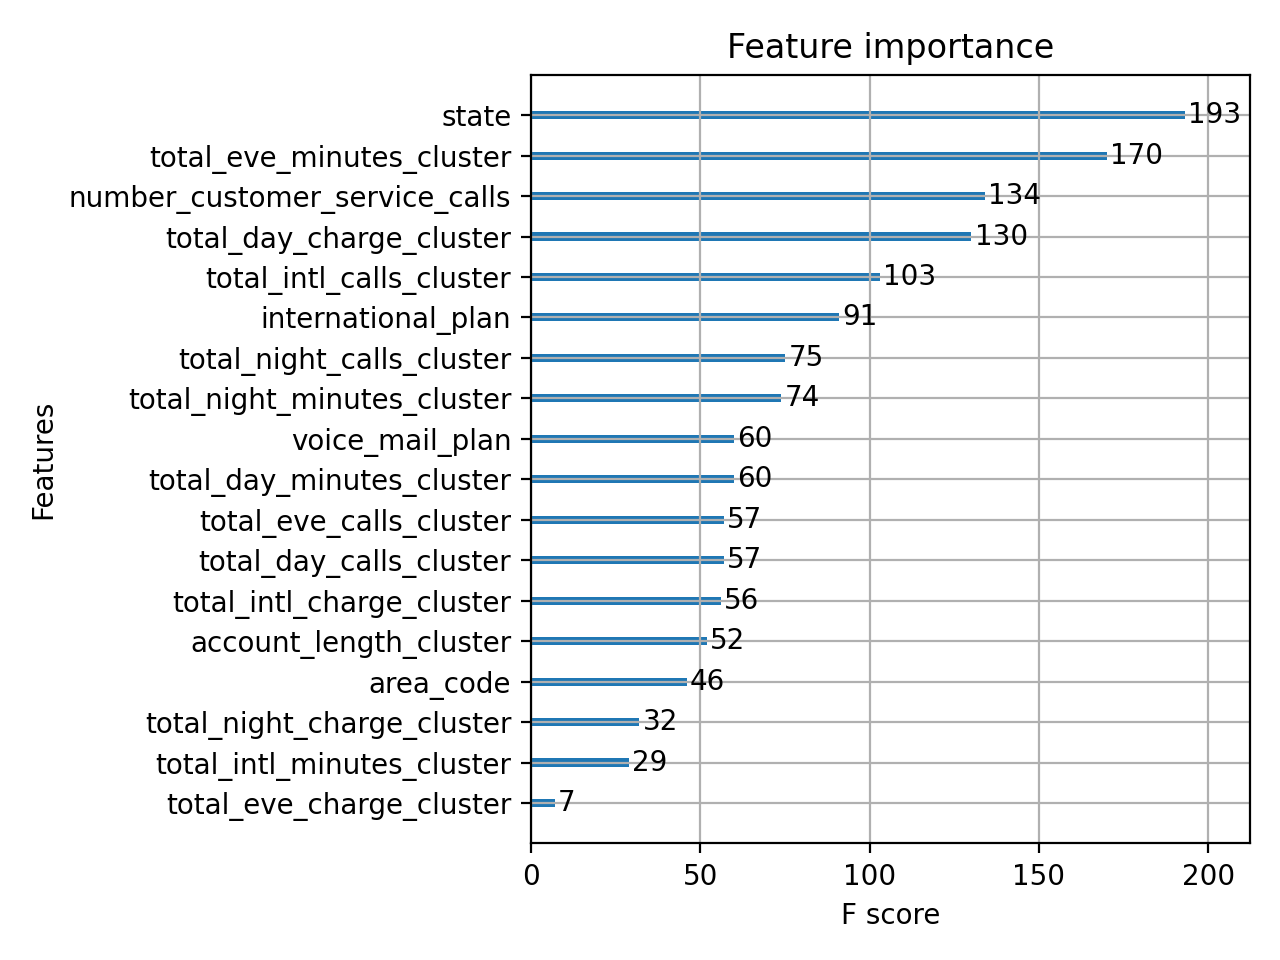

In [122]:
xgboost.plot_importance(xgb_model_clustered)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


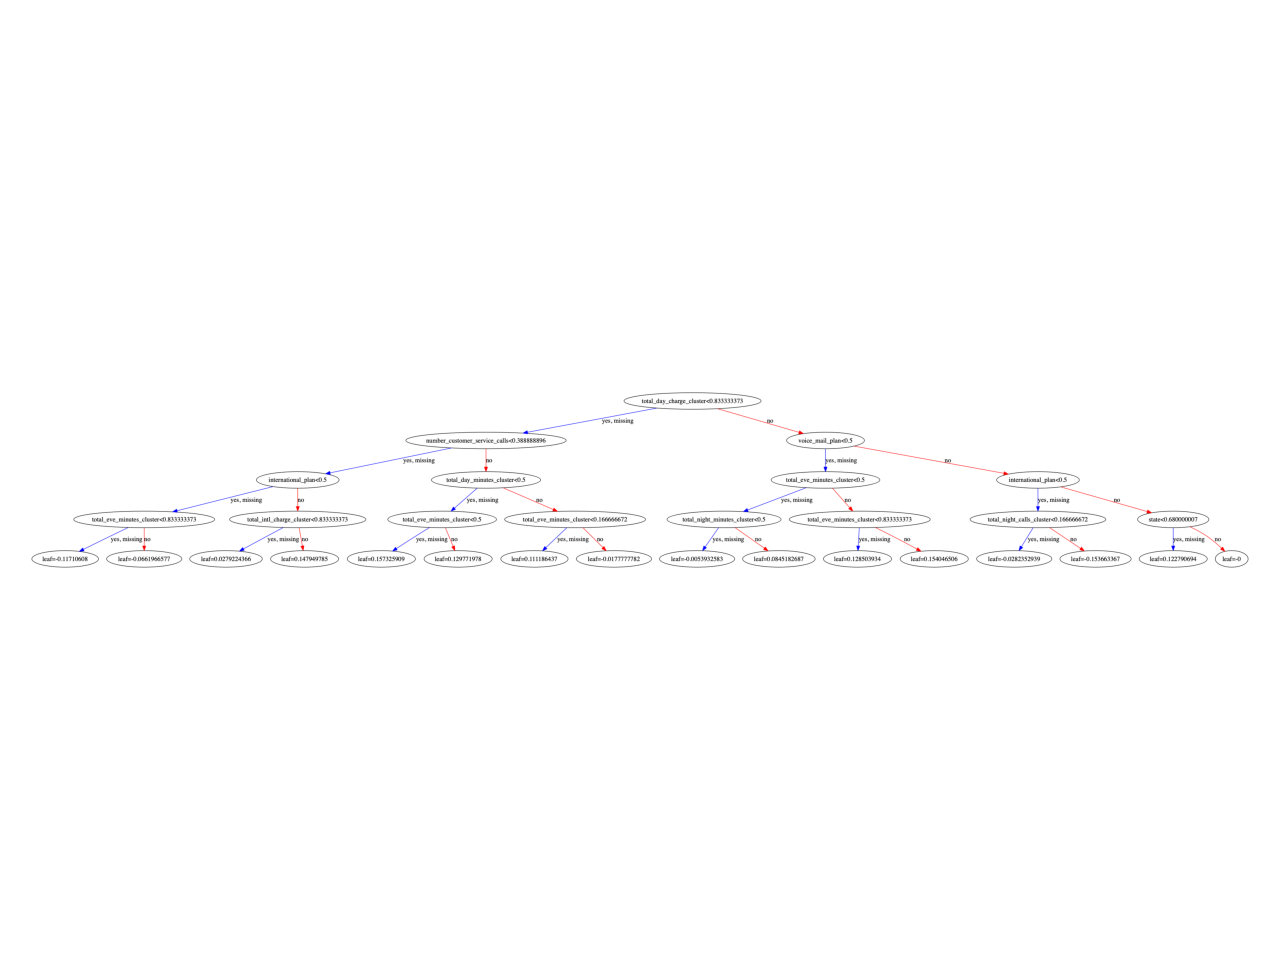

In [123]:
xgboost.plot_tree(xgb_model_clustered)
plt.tight_layout()
plt.show()

## 7. Saving the optimal model 

> *Comment* : Lets __finally fit/train the optimal xgboost model on all training data__ before pickling the model. Note: The first model is being saved since clustering did not improve the accuracy

In [152]:
xgb_model_optimal = xgboost.XGBClassifier(objective='binary:logistic',
                                         max_depth = search_results.best_params_['max_depth'],
                                         gamma = search_results.best_params_['gamma'],
                                         scale_pos_weight = 6,
                                         learning_rate = search_results.best_params_['learning_rate']).fit(X, y)

/usr/local/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [61]:
xgb_model_optimal.save_model('model/xgb_final.pkl')